In [1]:
import numpy as np
import porespy as ps
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sns
import skimage as ski
import tqdm
import pandas as pd
import scipy.stats

imageSize = 250

primaryImage = np.load('subBeadPackPy250_justSpheres.npy')
secondaryImage = np.load('finalSimFile3D250.npy')
primaryImage[primaryImage == 255] = 1

primaryImage = np.transpose(primaryImage)
secondaryImage = np.transpose(secondaryImage)

velSecondaryMat = sio.loadmat('velNormSecondary.mat')
velDataNormSecondary = velSecondaryMat['velNorm']

velPrimaryMat = sio.loadmat('velNormPrimary.mat')
velDataNormPrimary = velPrimaryMat['velNorm']

resolution = 16.81E-6 # adding resolution in meters

# Plot pore space and velocity

Plot the sample with secondary porosity

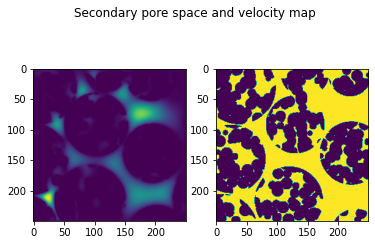

In [2]:
slice = 35

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Secondary pore space and velocity map')
p1.imshow(velDataNormSecondary[:,:,slice])
p2.imshow(secondaryImage[:,:,slice])

fig.savefig('secondaryPoreImage.png')


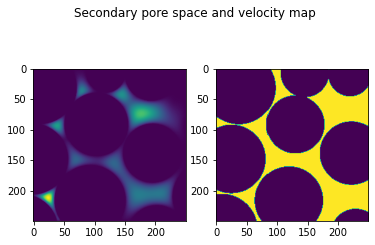

In [3]:
slice = 35

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Secondary pore space and velocity map')
p1.imshow(velDataNormPrimary[:,:,slice])
p2.imshow(primaryImage[:,:,slice])

fig.savefig('primaryPoreImage.png')

# Extract pore network information

In [4]:
snowFiltSecondary = ps.filters.snow_partitioning(im=secondaryImage,r_max=4,sigma=0.4, return_all=True)
poreInfoSecondary = ps.networks.regions_to_network(snowFiltSecondary.regions, dt=snowFiltSecondary.dt)

nRegions = np.unique(snowFiltSecondary.regions).size
secondaryPoreDiamVec = np.zeros(nRegions,)

for a in range(0, poreInfoSecondary['pore.diameter'].size):
    secondaryPoreDiamVec[a] = poreInfoSecondary['pore.diameter'][a]

secondaryRegions = snowFiltSecondary.regions

------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  1436
Peaks after trimming saddle points:  938
Peaks after trimming nearby peaks:  922
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 922/922 [00:09<00:00, 92.46it/s] 


In [5]:
snowFiltPrimary = ps.filters.snow_partitioning(im=primaryImage,r_max=4,sigma=0.4, return_all=True)
poreInfoPrimary = ps.networks.regions_to_network(snowFiltPrimary.regions, dt=snowFiltPrimary.dt)

nRegions = np.unique(snowFiltSecondary.regions).size
primaryPoreDiamVec = np.zeros(nRegions,)

for a in range(0, poreInfoPrimary['pore.diameter'].size):
    primaryPoreDiamVec[a] = poreInfoPrimary['pore.diameter'][a]

primaryRegions = snowFiltPrimary.regions

------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  113
Peaks after trimming saddle points:  104
Peaks after trimming nearby peaks:  93
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 93/93 [00:05<00:00, 18.06it/s]


In [ ]:
ps.io.to_vtk(secondaryRegions,'snowRegionsSecondary')
ps.io.to_vtk(primaryRegions,'snowRegionsPrimary')

# Bin extracted pore diameter data for plotting

In [6]:
# Bin pore diameter data
#max(poreInfo['pore.diameter'])
#min(poreInfo['pore.diameter'])
n_bins = 100

primaryPoreBins = np.linspace(0.1,60,n_bins)
primaryPoreDiamVec = poreInfoPrimary['pore.diameter']
primaryBinnedInd = np.digitize(primaryPoreDiamVec, primaryPoreBins)

allKeys = np.round(primaryPoreBins,2)
primaryBinnedPoreDiam = dict.fromkeys(allKeys)

for i in primaryBinnedPoreDiam.keys():
    primaryBinnedPoreDiam[i] = []

# currently storing all of the diameters of a pore for a binned pore size
for i in range(1, len(primaryBinnedInd)):
    key=primaryPoreBins[primaryBinnedInd[i]]
    key = round(key,2)
    primaryBinnedPoreDiam[key].append(primaryPoreDiamVec[i])
    #binnedPoreDiam[key].append(poreDispVector[i])

#regionLabel[i].append
secondaryPoreBins = np.linspace(0.1,60,n_bins)
secondaryPoreDiamVec = poreInfoSecondary['pore.diameter']
secondaryBinnedInd = np.digitize(secondaryPoreDiamVec, secondaryPoreBins)

allKeys = np.round(secondaryPoreBins,2)
secondaryBinnedPoreDiam = dict.fromkeys(allKeys)

for i in secondaryBinnedPoreDiam.keys():
    secondaryBinnedPoreDiam[i] = []

# currently storing all of the diameters of a pore for a binned pore size
for i in range(1, len(secondaryBinnedInd)):
    key=secondaryPoreBins[secondaryBinnedInd[i]]
    key = round(key,2)
    secondaryBinnedPoreDiam[key].append(secondaryPoreDiamVec[i])
    #binnedPoreDiam[key].append(poreDispVector[i])
#regionLabel[i].append


# Plot distribution of pore diameter

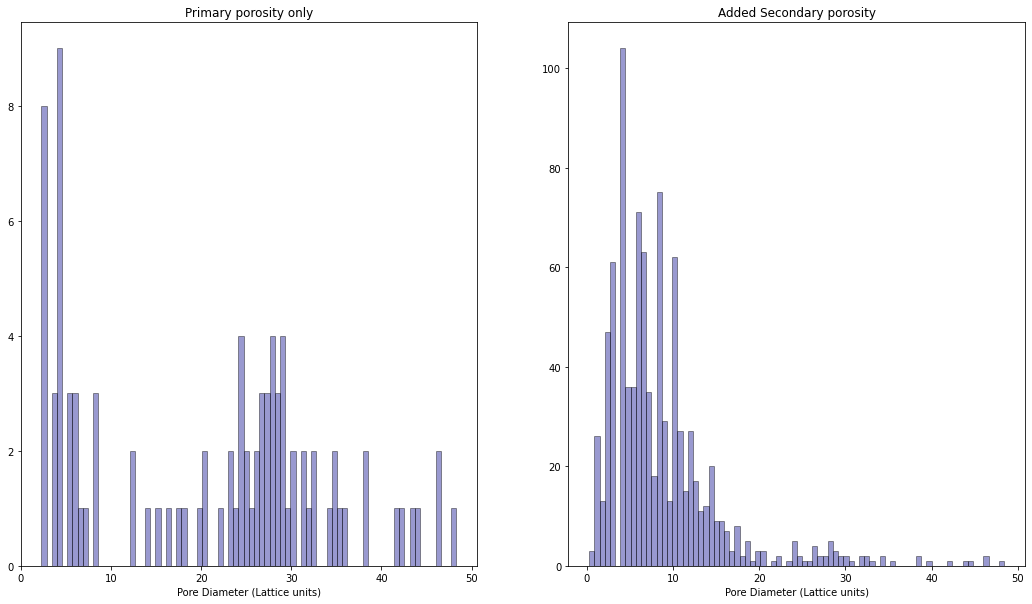

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
sns.distplot(primaryPoreDiamVec, ax=axes[0], hist=True, kde=False,
             bins=int(80), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes[0].set_title('Primary porosity only')
axes[0].set_xlabel('Pore Diameter (Lattice units)')

sns.distplot(secondaryPoreDiamVec, ax=axes[1], hist=True, kde=False,
             bins=int(80), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes[1].set_title('Added Secondary porosity')
axes[1].set_xlabel('Pore Diameter (Lattice units)')

fig.savefig('poreDiamHist.png')

### I will say pore diameter > 20 units are "big pores"

# Skeleton implementation

In [8]:
secondaryRegionData = ps.metrics.regionprops_3D(snowFiltSecondary.regions) #Gives properties for each region
#primaryRegionData = ps.metrics.regionprops_3D(snowFiltPrimary.regions)

100%|██████████| 922/922 [01:07<00:00, 13.69it/s]


------------------------------------------------------------
Calculating regionprops


Find skeleton for secondary image and collect info

In [10]:
len(np.unique(secondaryRegions))

923

In [9]:
# Skeleton for all pores
cubeSize = len(secondaryImage)
visit = np.zeros(len(np.unique(secondaryRegions)))
secondaryPoreDiamImage = np.zeros(secondaryImage.shape)
allSecondaryRegions = np.unique(secondaryRegions)
tempImage = np.zeros(secondaryRegions.shape)
secondaryPoreDiamVectorSkeleton = np.zeros(len(allSecondaryRegions))

secondarySkelImage = ski.morphology.skeletonize(secondaryImage)

for a in tqdm.tqdm(range(0,len(allSecondaryRegions)), 'Main loop'):
            regionLabel = a
            if regionLabel != 0: # Don't want grains to be counted
                if visit[regionLabel] == 0:
                    visit[regionLabel] = 1
                    # Adjust indices for pore information, regionlabel = 0 is pore 1 in poreInfo
                    poreDiam = secondaryPoreDiamVec[regionLabel - 1]
                    secondaryPoreDiamImage[secondaryRegions == regionLabel] = poreDiam




Main loop: 100%|██████████| 923/923 [00:15<00:00, 58.73it/s]


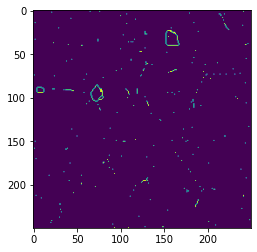

In [12]:
#secondarySkelImage[secondaryImage == 0] = 0
ps.io.to_vtk(secondarySkelImage,'secondarySkeletonWholeImage')
plt.imshow(secondarySkelImage[:,:,40])

secondaryImageOut = np.copy(secondaryImage)
secondaryImageOut = secondaryImageOut.astype(int)
secondaryImageOut[secondaryImage == 1] = 255
ps.io.to_vtk(secondaryImageOut,'secondaryImage')

# Now plot velocitites on skeleton and extract information

In [10]:
secondaryVelocitiesSkeleton = []
secondaryPoreDiamSkeleton = []
secondaryPoreRegionSkeleton = []

for a in tqdm.tqdm(range(0,cubeSize), 'Main loop'):
    for b in range(0,cubeSize):
        for c in range(0, cubeSize):
            # If the primary skeleton image is not zero, then save the velocity data
            # The primary skeleton image will be zero for all indices except the skeleton found above which
            # should be the values in the middle of all of the pores, no pore walls etc...
            # This array should contain the velocity data we want to use to define flow/no flow etc...
            if secondarySkelImage[a,b,c] != 0:
                secondaryVelocitiesSkeleton = np.append(secondaryVelocitiesSkeleton,velDataNormSecondary[a,b,c])
                secondaryPoreDiamSkeleton = np.append(secondaryPoreDiamSkeleton, secondaryPoreDiamImage[a,b,c])
                secondaryPoreRegionSkeleton = np.append(secondaryPoreRegionSkeleton, secondaryRegions[a,b,c])

Main loop: 100%|██████████| 250/250 [00:41<00:00,  5.98it/s]


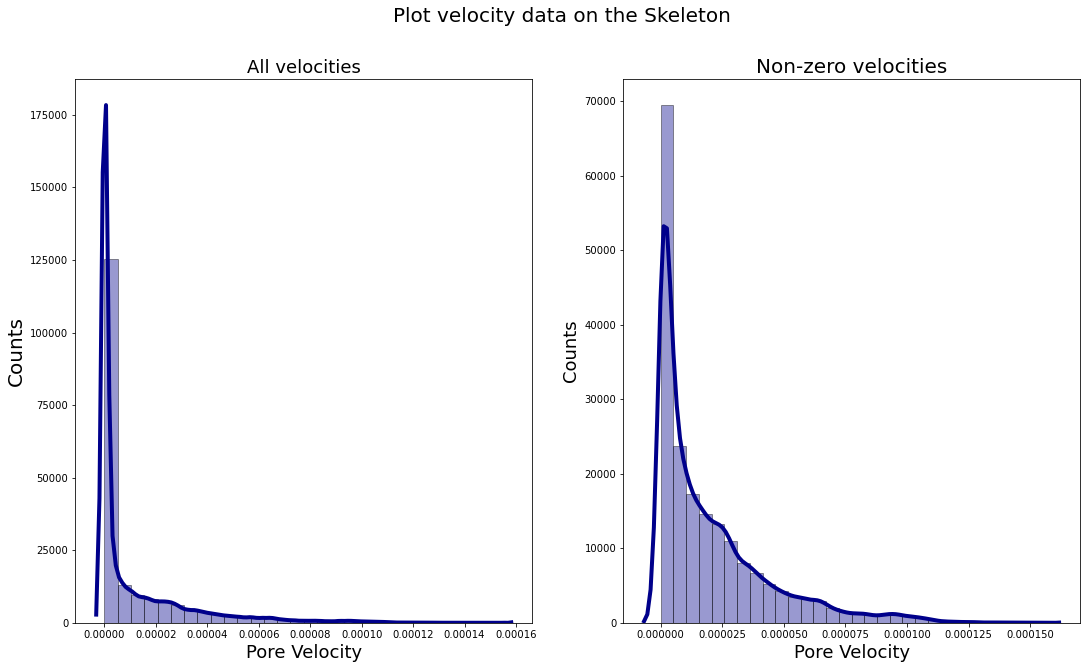

In [11]:
# The zeros seen here are truly no flow I think, they aren't pore walls and this is after the flow simulation, so
# even though the initial lattice state is v = 0, these are still zero

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Plot velocity data on the Skeleton', fontsize=20)

sns.distplot(secondaryVelocitiesSkeleton, ax=axes[0], hist=True, kde=True,
             color = 'darkblue', bins=30,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes[0].set_title('All velocities', fontsize=18)
axes[0].set_xlabel('Pore Velocity', fontsize=18)
axes[0].set_ylabel('Counts', fontsize=20)

sns.distplot(secondaryVelocitiesSkeleton[secondaryVelocitiesSkeleton != 0], bins=30, ax=axes[1], hist=True, kde=True,
             color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes[1].set_title('Non-zero velocities', fontsize=20)
axes[1].set_xlabel('Pore Velocity', fontsize=18)
axes[1].set_ylabel('Counts', fontsize=18)

fig.savefig('poreVelHistograms.png')

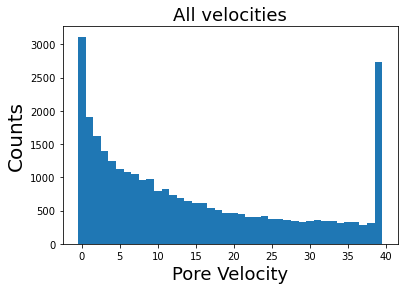

In [50]:
# # FIXME
# # This is definitely broken!!
# # Try defining your own bins
# #bins = [0.000001, 0.000002, 0.0000003, 0.0000004, 0.0000005]
# bins = np.linspace(0, 0.000008, num=40)
# bins = np.append(bins, 0.00001)
# #np.append(bins,0.0001)
# categories = pd.cut(secondaryVelocitiesSkeleton, bins)
# secondarySkelVel_binned = list(pd.value_counts(categories).reindex(categories.categories))
#
# fig, ax = plt.subplots(1, 1)
# ax.bar(range(len(bins)-1), secondarySkelVel_binned, width=1, align='center')
# #ax.set_xticklabels([x + 0.000001 for x in bins[:-1]])
# ax.set_title('All velocities', fontsize=18)
# ax.set_xlabel('Pore Velocity', fontsize=18)
# ax.set_ylabel('Counts', fontsize=20)
#
# plt.show()
# fig.savefig('poreVelHistogram.png')

# Plot pore velocities with pore diameters

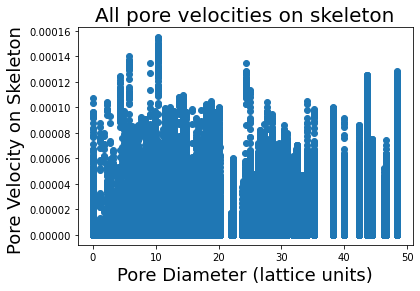

In [14]:
plt.scatter(secondaryPoreDiamSkeleton, secondaryVelocitiesSkeleton)
plt.xlabel('Pore Diameter (lattice units)', fontsize=18)
plt.ylabel('Pore Velocity on Skeleton ', fontsize=18)
plt.title('All pore velocities on skeleton', fontsize=20)

fig.savefig('allPoreVelocities.png')

Try taking computing a representative velocity threshold (use interquartile range)

In [15]:


IQR_PoreVelocity =  []
meanPoreVelocity =  []
skeletonPoreDiam = []
skeletonPoreRegion = []
poreRegions, indices = np.unique(secondaryPoreRegionSkeleton, return_index='True')

for a in tqdm.tqdm(range(0, len(allSecondaryRegions)), 'Main Loop'):
    currentRegion = a
    if currentRegion != 0:
        skeletonPoreVel = secondaryVelocitiesSkeleton[secondaryPoreRegionSkeleton == currentRegion]
        meanPoreVelocity = np.append(meanPoreVelocity, np.mean(skeletonPoreVel))
        IQR_PoreVelocity = np.append(IQR_PoreVelocity, scipy.stats.iqr(skeletonPoreVel, interpolation = 'midpoint'))

        # Adjust indices between regionProps and snow algorithm
        skeletonPoreDiam = np.append(skeletonPoreDiam, poreInfoSecondary['pore.diameter'][currentRegion-1] )

        skeletonPoreRegion = np.append(skeletonPoreRegion, currentRegion)

Main Loop:   0%|          | 0/923 [00:00<?, ?it/s]E:\Conda\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
Main Loop: 100%|██████████| 923/923 [00:00<00:00, 3858.75it/s]


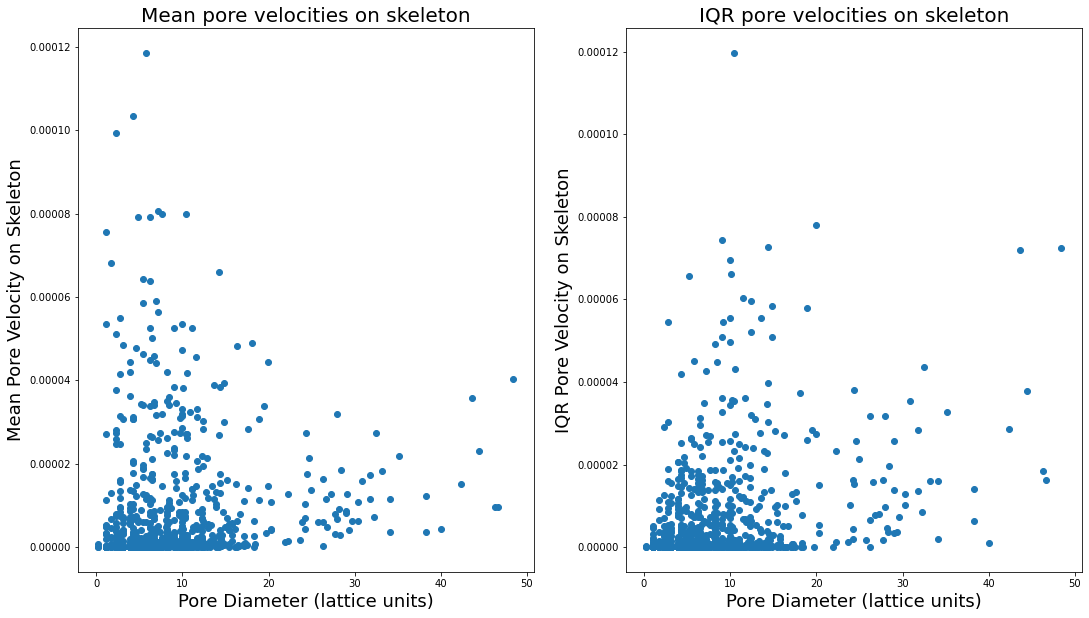

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
axes[0].scatter(skeletonPoreDiam, meanPoreVelocity)
axes[0].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[0].set_ylabel('Mean Pore Velocity on Skeleton', fontsize=18)
axes[0].set_title('Mean pore velocities on skeleton', fontsize=20)

axes[1].scatter(skeletonPoreDiam, IQR_PoreVelocity)
axes[1].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[1].set_ylabel('IQR Pore Velocity on Skeleton', fontsize=18)
axes[1].set_title('IQR pore velocities on skeleton', fontsize=20)

fig.savefig('poreVelAveraging.png')

Separate all pores with low velocity


In [17]:
# Best choice for this? hardcoded to 0 per discussion on 4/2
noFlowVelCutoff = 0 # 0.5 * 10 ** float(-5)
print(noFlowVelCutoff)

0


In [2]:
poreRegions, indices = np.unique(secondaryPoreRegionSkeleton, return_index='True')
noFlowRegions = skeletonPoreRegion[IQR_PoreVelocity == 0]
noFlowPoreDiam = skeletonPoreDiam[IQR_PoreVelocity == 0]
noFlowImage = np.zeros(secondaryImage.shape)
flowImage = np.copy(secondaryImage)
noFlowRegionVector = []

# This is unnecessary

# for a in tqdm.tqdm(range(0,len(noFlowRegions)), 'Main loop'):
#     regionInd = noFlowRegions[a]
#     print(regionInd)
#     noFlowRegionVector = np.append(noFlowRegionVector, regionInd)
#     #print('This is a no flow region:', regionInd)
#     noFlowImage[secondaryRegions == regionInd] =  1
#     flowImage[secondaryRegions == regionInd] = 0



NameError: name 'np' is not defined

### Select pores that don't flow with large pore sizes

In [1]:
poreDiamThresh = 20

filtNoFlowPoreDiam = noFlowPoreDiam[noFlowPoreDiam > poreDiamThresh]

# plt.scatter(secondaryPoreDiamSkeletonFilt, secondaryVelocitiesSkeletonFilt)
# plt.xlabel('Pore Diameter (lattice units)', fontsize=18)
# plt.ylabel('Pore Velocity on Skeleton ', fontsize=18)
# plt.title('All pore velocities on skeleton', fontsize=20)
#
# fig.savefig('allPoreVelocities.png')


NameError: name 'noFlowPoreDiam' is not defined